In [1]:
# Read in the data
import pandas as pd
import numpy as np

df = (pd.read_csv('data/data_2.csv', parse_dates=['Time'])
     .set_index('Time')
     )
df

,Usage
Time,
2022-01-10 00:00:00,0.45
2022-01-10 00:15:00,0.02
2022-01-10 00:30:00,0.02
2022-01-10 00:45:00,0.09
2022-01-10 01:00:00,0.10
...,...
2023-05-31 22:45:00,0.35
2023-05-31 23:00:00,0.24
2023-05-31 23:15:00,0.04


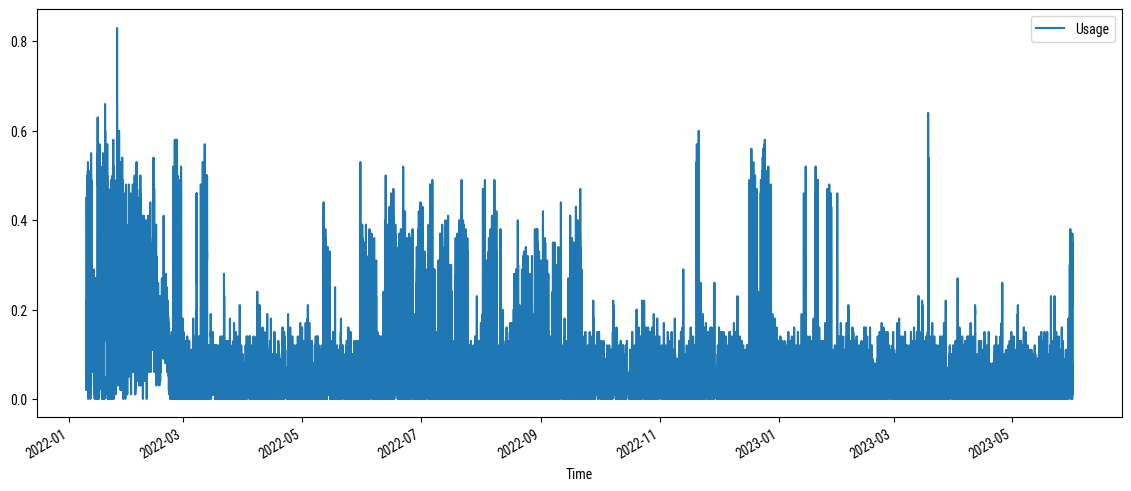

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Roboto Condensed'

# Plot the data
fig, ax = plt.subplots(figsize=(14, 6))
df.plot(ax=ax)
plt.show()

## Train/test split

In [10]:
test

,Usage
Time,
2023-01-10 00:00:00,0.04
2023-01-10 00:15:00,0.03
2023-01-10 00:30:00,0.04
2023-01-10 00:45:00,0.03
2023-01-10 01:00:00,0.03
...,...
2023-05-31 22:45:00,0.35
2023-05-31 23:00:00,0.24
2023-05-31 23:15:00,0.04


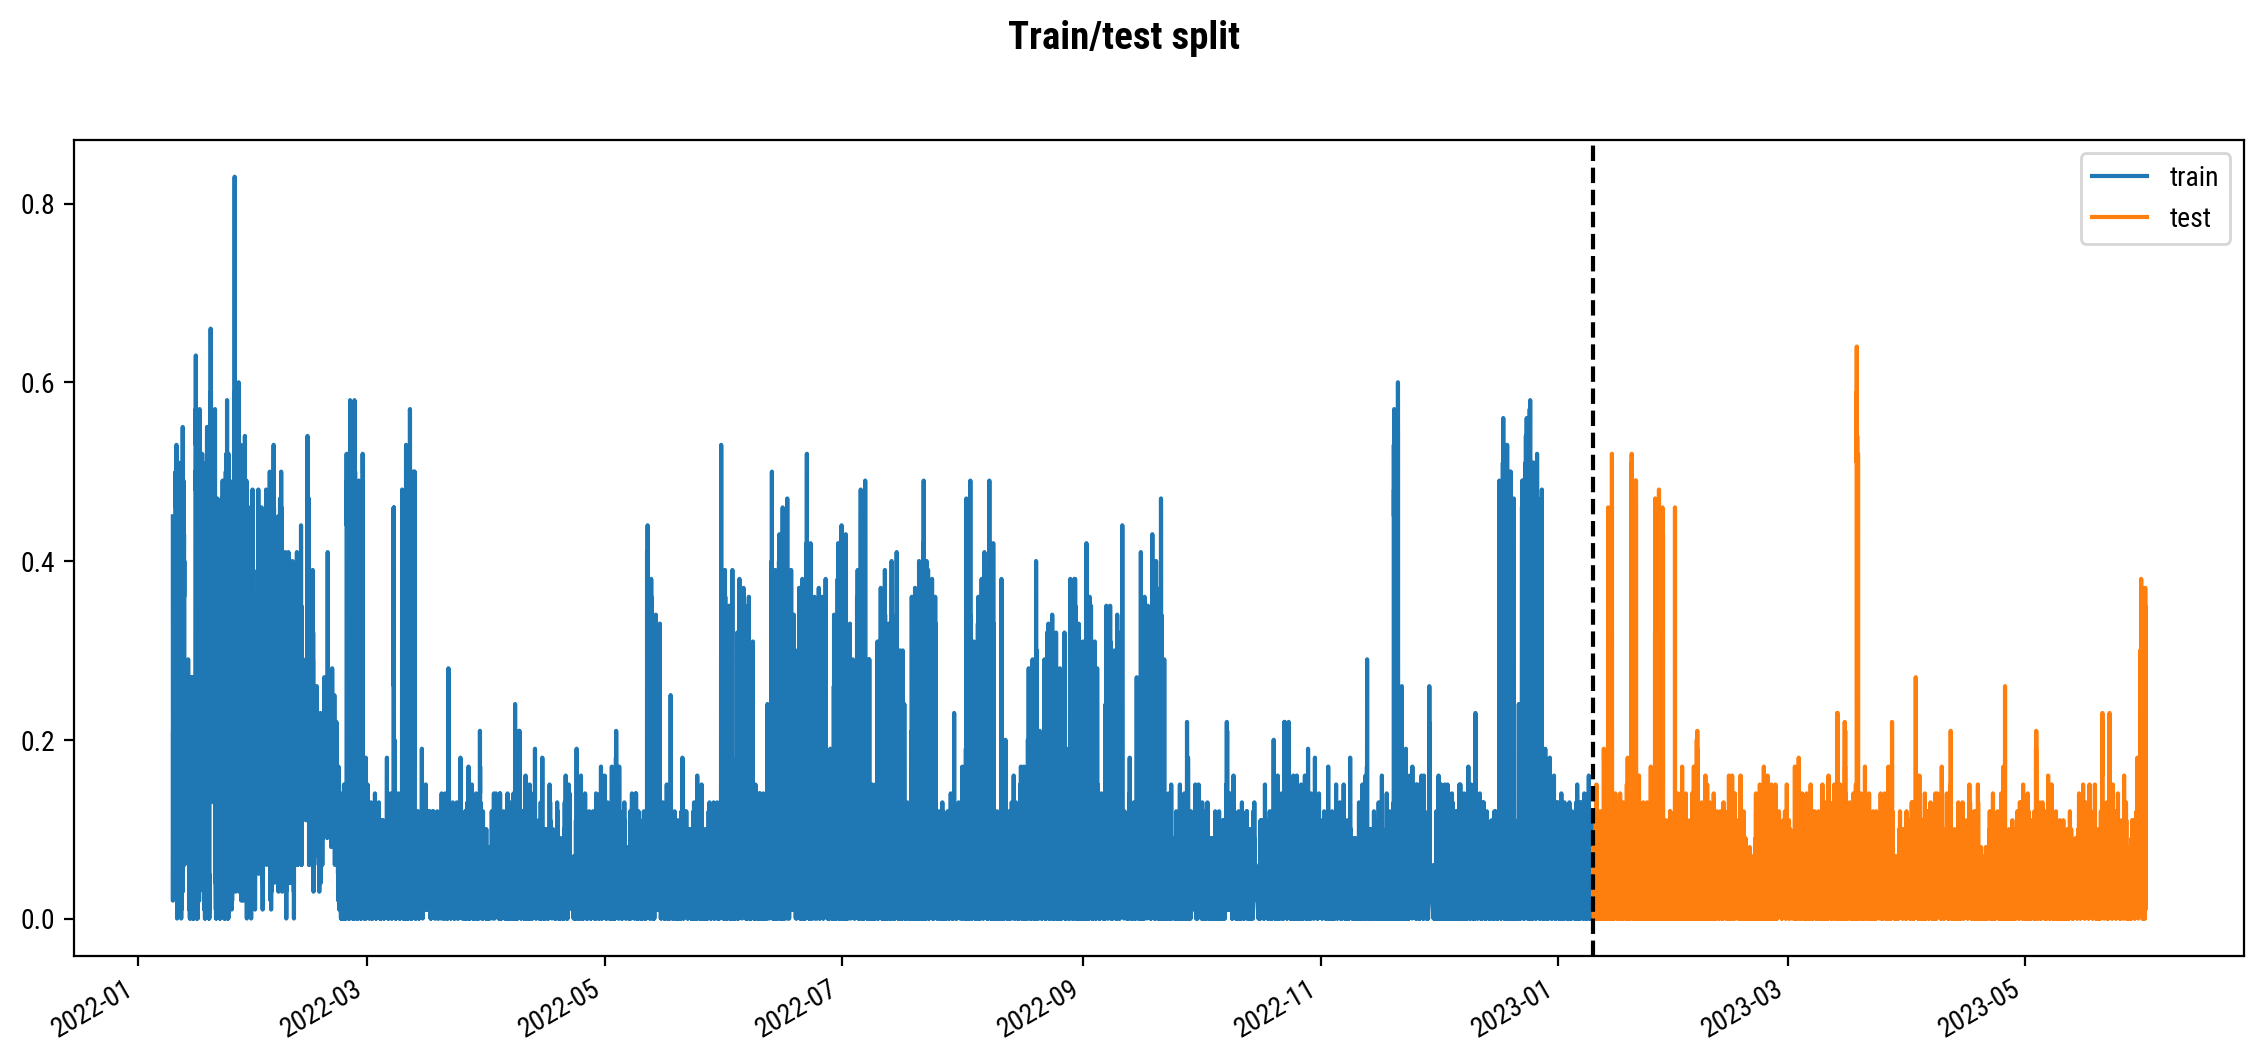

In [3]:
# split train to be from 2022-01-10 to 2023-01-10
train = df.loc[df.index < '2023-01-10']
test = df.loc[df.index >= '2023-01-10']

# Visualize how data is split
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
train.plot(ax=ax, xlabel='')
test.plot(ax=ax, xlabel='')
fig.suptitle('Train/test split', fontsize=14, fontweight='bold')
ax.axvline('2023-01-10', color='k', linestyle='--')
ax.legend(['train', 'test']);

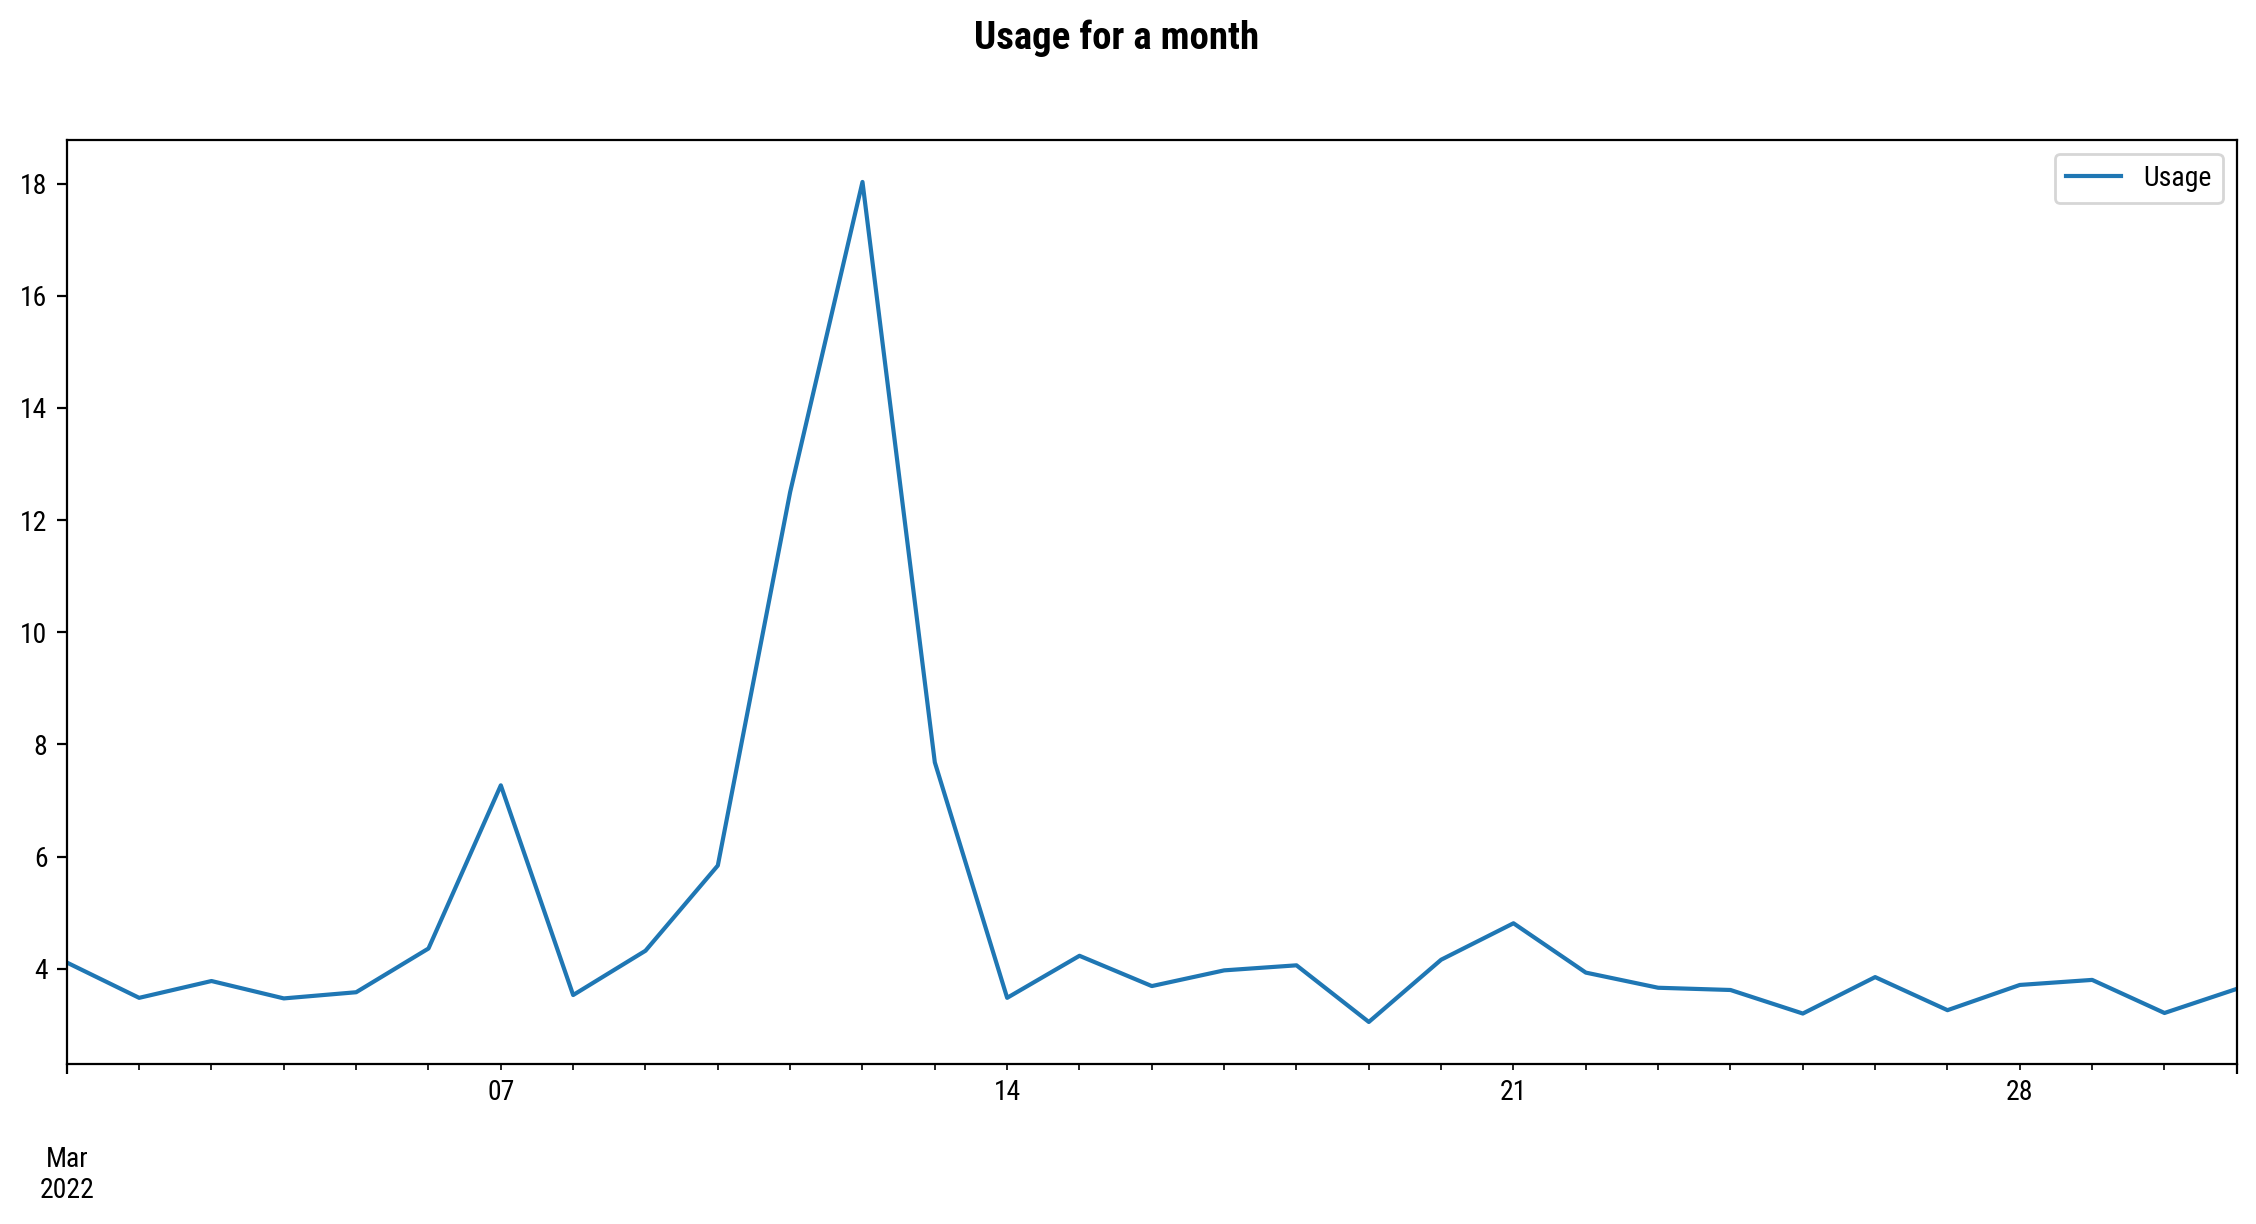

In [4]:
# Visualize daily usage of a month's worth of data
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
(df
 .loc['2022-03-01':'2022-03-31']
 .resample('d')
 .sum()
 .plot(ax=ax, xlabel='')
 )
fig.suptitle('Usage for a month', fontsize=14, fontweight='bold');

## Feature engineering

In [5]:
def create_cols(df):
    """Create time series cols based on time series index"""
    return (df
    .assign(hour=lambda df_: df_.index.hour,
            dayofweek=lambda df_: df_.index.dayofweek,
            quarter=lambda df_: df_.index.quarter,
            month=lambda df_: df_.index.month,
            year=lambda df_: df_.index.year,
            dayofyear=lambda df_: df_.index.dayofyear)
    )

df = create_cols(df)
df

,Usage,hour,dayofweek,quarter,month,year,dayofyear
Time,,,,,,,
2022-01-10 00:00:00,0.45,0,0,1,1,2022,10
2022-01-10 00:15:00,0.02,0,0,1,1,2022,10
2022-01-10 00:30:00,0.02,0,0,1,1,2022,10
2022-01-10 00:45:00,0.09,0,0,1,1,2022,10
2022-01-10 01:00:00,0.10,1,0,1,1,2022,10
...,...,...,...,...,...,...,...
2023-05-31 22:45:00,0.35,22,2,2,5,2023,151
2023-05-31 23:00:00,0.24,23,2,2,5,2023,151
2023-05-31 23:15:00,0.04,23,2,2,5,2023,151


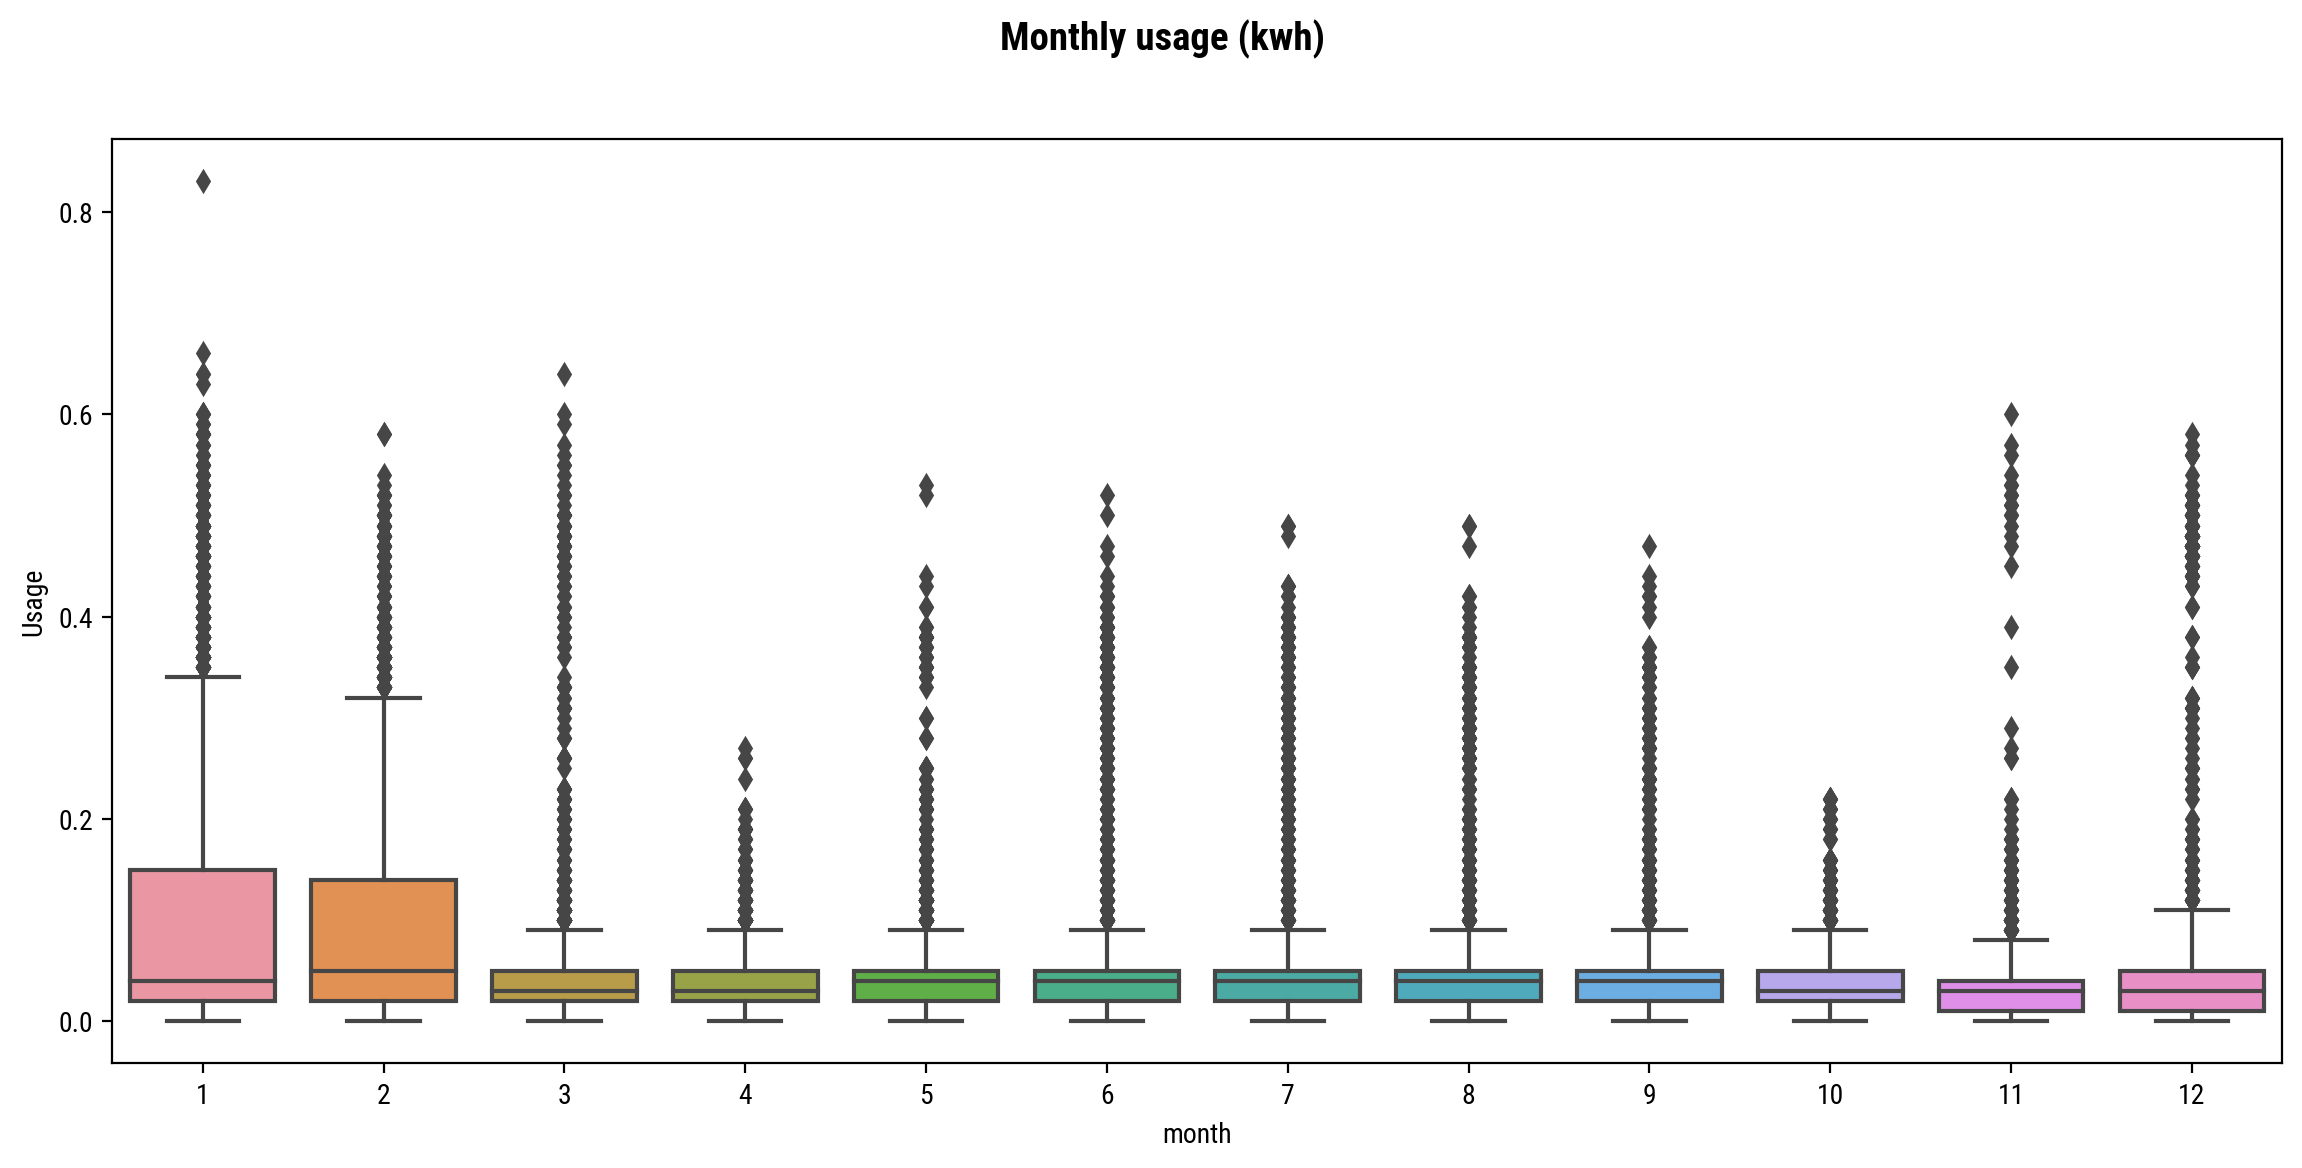

In [6]:
# Visualize feature target relationship
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
sns.boxplot(x='month', y='Usage', data=df)
fig.suptitle('Monthly usage (kwh)', fontsize=14, fontweight='bold');

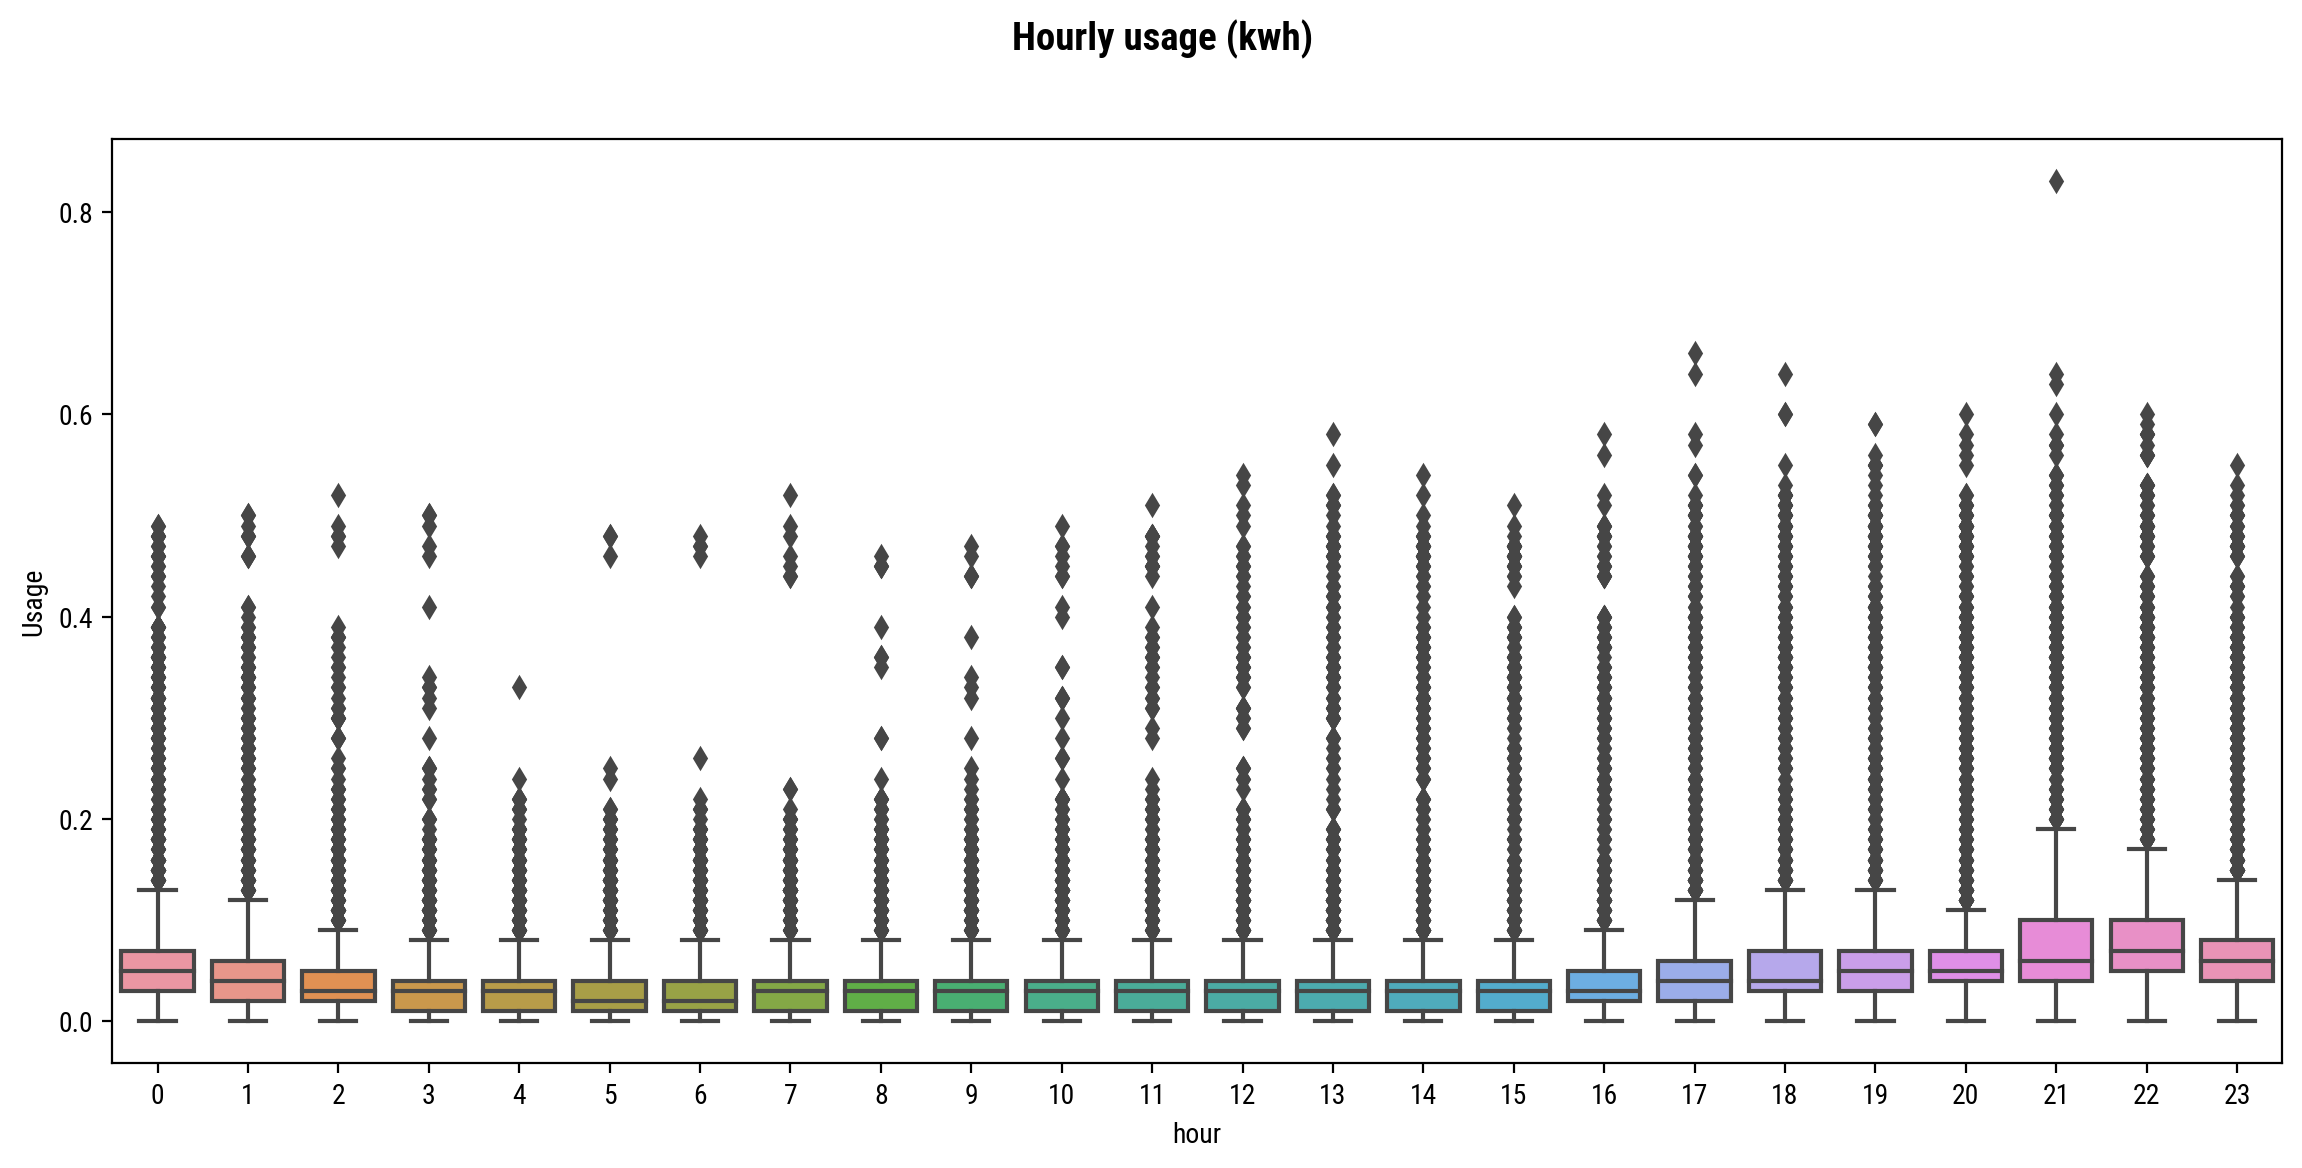

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
sns.boxplot(x='hour', y='Usage', data=df)
fig.suptitle('Hourly usage (kwh)', fontsize=14, fontweight='bold');

## Train the model

In [12]:
train = create_cols(train)
test = create_cols(test)

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Partition features and target
FEATURES = df.iloc[:, 1:].columns
TARGET = df.iloc[:, [0]].columns

# Separate train and test
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
# Create model
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.001,
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.44370	validation_1-rmse:0.46581


[100]	validation_0-rmse:0.40231	validation_1-rmse:0.42245
[200]	validation_0-rmse:0.36494	validation_1-rmse:0.38331
[300]	validation_0-rmse:0.33120	validation_1-rmse:0.34796
[400]	validation_0-rmse:0.30078	validation_1-rmse:0.31602
[500]	validation_0-rmse:0.27335	validation_1-rmse:0.28716
[600]	validation_0-rmse:0.24865	validation_1-rmse:0.26112
[700]	validation_0-rmse:0.22640	validation_1-rmse:0.23769
[800]	validation_0-rmse:0.20638	validation_1-rmse:0.21658
[900]	validation_0-rmse:0.18840	validation_1-rmse:0.19744
[999]	validation_0-rmse:0.17242	validation_1-rmse:0.18032


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
# Check feature importance
feature_importance = pd.DataFrame(reg.feature_importances_,
             reg.feature_names_in_,
             columns=['Importance'])

<Axes: >

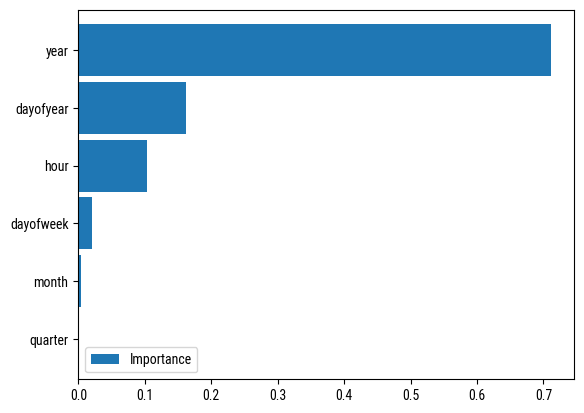

In [30]:
(feature_importance
 .sort_values('Importance', ascending=True)
 .plot.barh(width=.9)
 )

## Forcast on test data

In [33]:
test['predictions'] = reg.predict(X_test)



In [35]:
df = df.merge(
    test[['predictions']],
    how='left',
    left_index=True,
    right_index=True
)

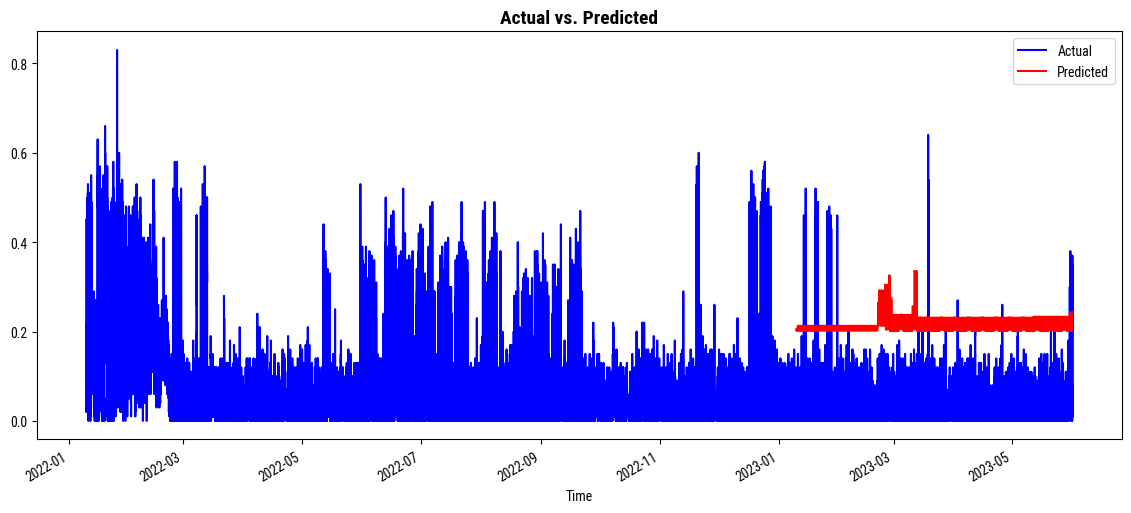

In [41]:
# Visualize actual and predicted together
ax = df.loc[:, ['Usage']].plot(figsize=(14, 6), color='blue')
df.loc[:, ['predictions']].plot(ax=ax, color='r')
ax.legend(['Actual', 'Predicted'])
ax.set_title('Actual vs. Predicted', fontsize=14, fontweight='bold');

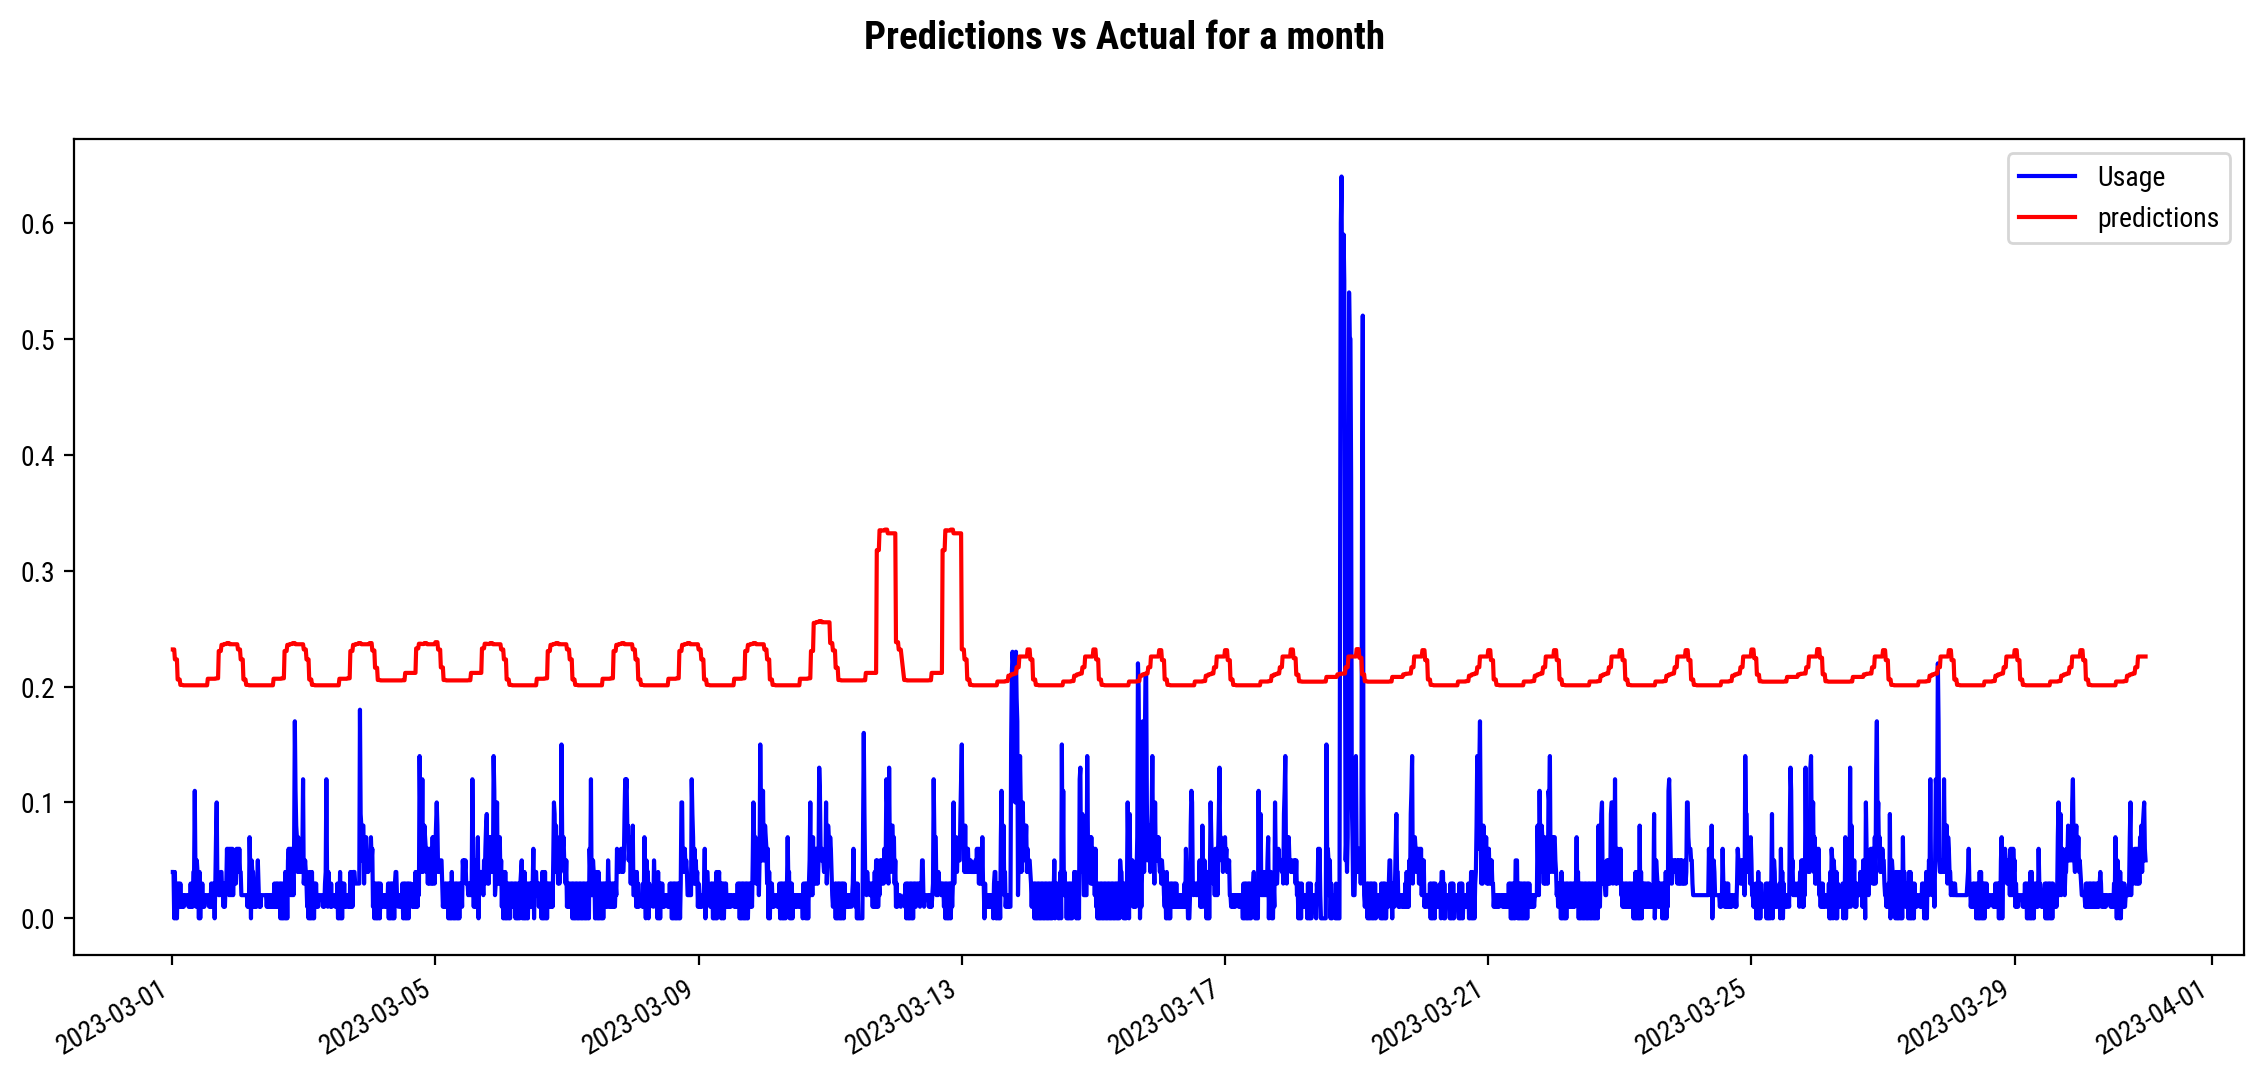

In [46]:
# Visualize predictions for a month
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
(df
 .loc[(df.index > '2023-03-01') & (df.index < '2023-03-31'), ['Usage', 'predictions']]
 .plot(figsize=(14, 6), color=['blue', 'r'], ax=ax, xlabel='')
 )
fig.suptitle('Predictions vs Actual for a month', fontsize=14, fontweight='bold');


## Evaluate model
Look at the worst and best predicted days.

In [49]:
# Calculate RMSE
score = np.sqrt(mean_squared_error(test['Usage'], test['predictions']))
print(f'RMSE score on test set: {score:.2f}')

RMSE score on test set: 0.18


In [57]:
# Calcuate the error
(test
 .assign(error=lambda df_: np.abs(df_['Usage'] - df_['predictions']),
         date=lambda df_: df_.index.date)
 .groupby('date')
 .error
 .mean()
 .sort_values(ascending=False)
#  .head(5) # Top 5 days with highest error
 .tail(5) # Top 5 days with lowest error
 )

date
2023-05-29    0.161423
2023-02-05    0.160752
2023-05-30    0.158279
2023-03-13    0.153140
2023-05-22    0.151054
Name: error, dtype: float64